In [1]:
import os
import pandas as pd
# from random import sample
import numpy as np
import matplotlib.pyplot as plt
# from scipy.stats import norm
# from scipy.integrate import simpson, quad
# import scipy.stats as ss
# from scipy.integrate import cumtrapz, cumulative_trapezoid
# from scipy.interpolate import CubicSpline
from astropy.cosmology import FlatLambdaCDM
from tqdm import tqdm
# import time
# import astropy.units as u
# import astropy.cosmology.units as cu
# import scipy.fft as fft
# from astropy.cosmology import z_at_value
# from pathlib import Path
# import json

import torch
import swyft

def th_phi_from_ra_dec_rad(ra, dec):
    """
    Compute :math:`\\theta` and :math:`\phi` in :math:`\\rm rad` from :math:`\\alpha` and :math:`\delta` in :math:`\\rm rad`.
    
    :param array or float ra: The :math:`\\alpha` sky position angle(s) to convert, in :math:`\\rm rad`.
    :param array or float dec: The The :math:`\delta` sky position angle(s) angle(s) to convert, in :math:`\\rm rad`.
    
    :return: :math:`\\theta` and :math:`\phi` in :math:`\\rm rad`.
    :rtype: tuple(array, array) or tuple(float, float)
    
    """
    theta = 0.5 * np.pi - dec
    phi = ra
    return theta, phi

true_cosmo = FlatLambdaCDM(H0 = 70,Om0 = 0.25)

In [2]:
%matplotlib inline

In [3]:
DEVICE = 'gpu' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(0)
np.random.seed(0)

In [4]:
from SimulatorPackages import GWSampler, EventSimulator, RedshiftSampler#, GalaxySampler

TEOBResumS is not installed, only the GWFAST waveform models are available, namely: TaylorF2, IMRPhenomD, IMRPhenomD_NRTidalv2, IMRPhenomHM and IMRPhenomNSBH
Available devices: [cuda(id=0)]


# Subsampled Universe

In [5]:
# ### CREATE GALAXY CATALOG
# # gal_data = pd.read_csv('SBI_galaxies.csv',index_col=0)
# # gal_data
# galaxies_redshift = np.genfromtxt('micecat_451.csv',skip_header=1)
# galaxies_ra       = np.random.uniform(0, 2*np.pi, len(galaxies_redshift)) # rad
# galaxies_dec      = np.arcsin(np.random.uniform(-1, 1, len(galaxies_redshift))) # rad

# galaxies_dict = pd.DataFrame({'true_redshift_gal': galaxies_redshift,
#                               'ra'  : galaxies_ra,
#                               'dec' : galaxies_dec
#                               })

# theta_, phi_ = th_phi_from_ra_dec_rad(galaxies_ra,galaxies_dec) 
# galaxies_dict['theta'] = theta_
# galaxies_dict['phi']  = phi_

# ### SAVE
# galaxies_dict.to_csv('gal_catalog.csv',index = False)

In [6]:
### READ
galaxies_dict = pd.read_csv('gal_catalog.csv')

In [7]:
# ################ TEST ################
# ### Choose N_events
# N_events = int(5)

# ### Sample N_events locations
# ind_sample = np.random.choice(len(galaxies_dict), size=N_events, replace = False)

# location_sample = galaxies_dict.iloc[ind_sample].reset_index(drop=True)

# ### Sample N_events GW params
# my_GW_sampler = GWSampler(host_g = location_sample)
# my_GW_sampler.sample_BBH()
# gw_params = my_GW_sampler.BBH

# ### Set up the event simulator
# my_event_simulator = EventSimulator(gw_params.copy(), filt_snr = 12., filt_err = 0.05, batch = 100)
# my_event_simulator.host_g

In [8]:
### Build the simulator
class Simulator(swyft.Simulator):
    def __init__(self, galaxies_dict, N_events):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.galaxies_dict = galaxies_dict
        self.H0s        = np.random.uniform(low=60, high=80, size=len(galaxies_dict))
        self.Nbins      = len(galaxies_dict)
        self.redshifts  = galaxies_dict['true_redshift_gal'].values
        self.thetag     = galaxies_dict['theta'].values
        self.phig       = galaxies_dict['phi'].values
        self.pass_events  = []
        # self.trust_scores = []
        self.sigmas_arr   = []
        self.N_events   = N_events

    def calc_m(self, z):
        ########################################
        ############# Marginalising ############
        ### Sample N_events locations
        ind_sample = np.random.choice(len(self.galaxies_dict), size=self.N_events, replace = False)
        galaxies_sample = galaxies_dict.iloc[ind_sample].reset_index(drop=True)

        ### Sample N_events GW params
        my_GW_sampler = GWSampler(host_g = galaxies_sample)
        my_GW_sampler.sample_BBH()
        gw_params = my_GW_sampler.BBH
        # print(gw_params.keys())
        ########################################
        cosmo = FlatLambdaCDM(H0  = z,
                              Om0 = 0.3,
                              Ob0 = 0.044)
        dLs = cosmo.luminosity_distance(self.redshifts[ind_sample]).value/1000 #Gpc
        m = np.array([self.thetag[ind_sample],self.phig[ind_sample],dLs]).T
        
        self.gw_params = gw_params
        self.gw_params['dL'] = m.T[2]
        
        return m.astype(np.float32)

    def calc_x(self, m):
        temp_df = self.gw_params
        # temp_df['dL'] = m.T[2]
        
        GW_data = EventSimulator(temp_df, filt_snr = 12, filt_err = 0.05, batch = 150)
        GW_data.simulate()
        sigmas = GW_data.host_g[['sigma_theta','sigma_phi','sigma_dL']].values
        self.sigmas_arr.append(sigmas)

        pass_mask = GW_data.host_g['PASS'].values  # Boolean mask (True = trusted event)
        self.pass_events.append(pass_mask)

        # invarr = 1/sigmas.T[2] #sigma d_L
        # self.trust_scores.append(invarr/np.linalg.norm(invarr))

        result = m + np.random.randn(*np.shape(m)) * sigmas
        return result.astype(np.float32)


    def build(self, graph):  # the print statements are for illustration only
        print("--- Building graph!")
        z = graph.node('z', lambda: np.random.uniform(low=50, high=90))
        m = graph.node('m', self.calc_m, z)
        x = graph.node('x', self.calc_x, m)

        # # Store event trust scores
        # trust_scores = graph.node('trust', lambda: self.pass_events[-1])

        print("--- x =", x)
        print("--- m =", m)
        print("--- z =", z)
        # print("--- trust =", trust_scores)  # Debugging: print trust scores

In [9]:
# ### TEST
# my_simulator = Simulator(galaxies_dict, N_events = 5)
# my_samples = my_simulator.sample(3)

## Generate samples

In [ ]:
for j in tqdm(range(100), desc="Processing"):
    my_simulator = Simulator(galaxies_dict, N_events = 100)
    sam = my_simulator.sample(20)

    sam['z'] = sam['z'].astype(np.float32)
    sam['m'] = sam['m'].astype(np.float32)
    sam['x'] = sam['x'].astype(np.float32)
    sam['sigmas'] = np.array(my_simulator.sigmas_arr).astype(np.float32)
    sam['pass']   = np.array(my_simulator.pass_events)
    # sam['trust']  = np.array(my_simulator.trust_scores).astype(np.float32)
    sam.keys()


    folder_path = "Data/Attempt_2/SBI_data"

    lst = os.listdir(folder_path)
    number_files = len(lst)

    file_path = folder_path+"/Sample"+str(number_files)+".pth"
    torch.save(sam, file_path)

Processing:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

/gpfs/home3/iliodis/SBI/SimulatorPackages.py:41: RuntimeWarning: overflow encountered in exp
  return (1 + np.exp(delta/m + delta/(m - delta)))**(-1)


--- Building graph!
--- x = Node('x', <bound method Simulator.calc_x of <__main__.Simulator object at 0x14d2742bff50>>, (Node('m', <bound method Simulator.calc_m of <__main__.Simulator object at 0x14d2742bff50>>, (Node('z', <function Simulator.build.<locals>.<lambda> at 0x14d27462a020>, ()),)),))
--- m = Node('m', <bound method Simulator.calc_m of <__main__.Simulator object at 0x14d2742bff50>>, (Node('z', <function Simulator.build.<locals>.<lambda> at 0x14d27462a020>, ()),))
--- z = Node('z', <function Simulator.build.<locals>.<lambda> at 0x14d27462a020>, ())
Change n to comply with host_g.
All available detectors are: ['L1', 'H1', 'Virgo', 'KAGRA', 'LIGOI', 'ETS', 'ETMR', 'ETSL', 'ETMRL45d', 'ETMRLpar', 'CE1Id', 'CE2NM', 'CE2NSW']
Using detectors ['ETMR', 'CE1Id', 'CE2NM']
Using ASD from file /home/iliodis/.local/lib/python3.11/site-packages/psds/ET-0000A-18.txt 
Initializing jax...
Jax local device count: 1
Jax  device count: 1


2025-06-09 13:54:18.500803: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.7 which is older than the ptxas CUDA version (12.8.93). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


# Read all samples and save data

In [9]:
folder_path = "Data/Attempt_2/SBI_data"

samples = []
for file_name in os.listdir(folder_path):
    samples.append(torch.load(folder_path+"/"+file_name,weights_only = False))

merged_dict = {key: np.concatenate([d[key] for d in samples]) for key in samples[0]}

new_dict_list = [dict([(key, merged_dict[key]) for key in ['z','m','x']])]
for j in range(50):
  sampled_x_arrays = np.random.normal(loc=merged_dict['m'], scale=merged_dict['sigmas'])
  new_dict = {'z'     : merged_dict['z'],
              'm'     : merged_dict['m'],
              'x'     : sampled_x_arrays,}
  new_dict_list.append(new_dict)

final_merged_dict = {key: np.concatenate([d[key] for d in new_dict_list]) for key in new_dict_list[0]}

final_merged_dict = swyft.lightning.simulator.Samples(final_merged_dict)

final_merged_dict['x'] = final_merged_dict['x'].astype(np.float32)
final_merged_dict['m'] = final_merged_dict['m'].astype(np.float32)
final_merged_dict['z'] = final_merged_dict['z'].astype(np.float32)

In [11]:
torch.save(merged_dict, "Data/SBI_merged_data/SBI_3400_samples.pth")

torch.save(final_merged_dict, "Data/SBI_merged_improved_data/SBI_3400x51_samples.pth")

## Load data and Split training and test set

In [10]:
import torch

In [11]:
samples = torch.load("Data/SBI_merged_improved_data/SBI_3400x51_samples.pth", weights_only = False)

In [12]:
len(samples['z'])

173400

In [13]:
n_tot   = len(samples['z'])
n_train = int(n_tot*0.80)
n_test  = n_tot - n_train

ind_train = np.random.choice(np.arange(n_tot), size=n_train, replace=False)
ind_tot   = np.arange(n_tot)
ind_test  = np.delete(ind_tot, ind_train)

### training set
train_samples = {}
train_samples['z'] = samples['z'][ind_train].astype(np.float32)
train_samples['m'] = samples['m'][ind_train].astype(np.float32)
train_samples['x'] = samples['x'][ind_train].astype(np.float32)

train_samples = swyft.lightning.simulator.Samples(train_samples)

### testing set
test_samples = {}
test_samples['z'] = samples['z'][ind_test].astype(np.float32)
test_samples['m'] = samples['m'][ind_test].astype(np.float32)
test_samples['x'] = samples['x'][ind_test].astype(np.float32)

test_samples = swyft.lightning.simulator.Samples(test_samples)

In [14]:
len(test_samples['z']), len(train_samples['z'])

(34680, 138720)

In [32]:
torch.save(test_samples, "Data/SBI_34680_test_samples.pth")
torch.save(train_samples, "Data/SBI_138720_train_samples.pth")

## Read training and test samples

In [15]:
# test_samples_single = torch.load("/content/drive/My Drive/MSc_Thesis/SBI_final_data/SBI_40_test_samples.pth")
# test_samples_mult   = torch.load("/content/drive/My Drive/MSc_Thesis/SBI_final_data/SBI_40x51_test_samples.pth")

test_samples        = torch.load("Data/SBI_34680_test_samples.pth", weights_only = False)
train_samples       = torch.load("Data/SBI_81600_train_samples.pth", weights_only = False)

In [16]:
train_samples['x'] = np.nan_to_num(train_samples['x'],0.)
test_samples['x'] = np.nan_to_num(test_samples['x'],0.)

In [32]:
### Sort
sorted_train_indices = np.argsort(train_samples['x'][:, :, 2], axis=1)
sorted_train_samples = np.take_along_axis(train_samples['x'], sorted_train_indices[:, :, np.newaxis], axis=1)
train_samples['x'] = sorted_train_samples

sorted_test_indices = np.argsort(test_samples['x'][:, :, 2], axis=1)
sorted_test_samples = np.take_along_axis(test_samples['x'], sorted_test_indices[:, :, np.newaxis], axis=1)
test_samples['x'] = sorted_test_samples

# Build network

In [191]:
# class SinActivation(torch.nn.Module):
#     def forward(self, x):
#         return torch.sin(x)

In [90]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()

        # 1D Convolutional Layers
        self.conv_layers = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels=3, out_channels=16, kernel_size=5, padding=2),
            torch.nn.ReLU(),
            torch.nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            torch.nn.ReLU()
        )

        # Fully connected layers
        self.fc_layers = torch.nn.Sequential(
            torch.nn.Linear(64 * 100, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 16),
            torch.nn.ReLU()
        )

        # Log-ratio estimator
        self.logratios = swyft.LogRatioEstimator_1dim(
            num_features=16,
            num_params=1,
            varnames='z'
        )

    def forward(self, A, B):
        x = A['x'].permute(0, 2, 1)  # Change shape to (batch, 3, 150)
        features = self.conv_layers(x)  # CNN extracts features
        features = features.view(features.shape[0], -1)  # Flatten

        embedding = self.fc_layers(features)
        logratios = self.logratios(embedding, B['z'].unsqueeze(-1))
        return logratios


In [91]:
# class Network(swyft.SwyftModule):
#     def __init__(self):
#         super().__init__()

#         # Feature extractor: Flatten and project down to a smaller dimension
#         self.embedding = torch.nn.Sequential(
#             torch.nn.Flatten(),  # Flatten (100,3) -> (300,)
#             torch.nn.Linear(300, 128),
#             # torch.nn.ReLU(),
#             SinActivation(),  # Use sine activation
#             torch.nn.Linear(128, 16),
#             torch.nn.ReLU(),
#             torch.nn.Linear(16, 4),  # Further reduce to 4 features
#             torch.nn.ReLU()
#         )

#         # Log-ratio estimator for a **single** parameter
#         self.logratios = swyft.LogRatioEstimator_1dim(
#             num_features=4,  # Matches final embedding output
#             num_params=1,    # Only one parameter to infer
#             varnames='z'
#             )

#     def forward(self, A, B):
#         embedding = self.embedding(A['x'])  # Process input
#         logratios = self.logratios(embedding, B['z'].unsqueeze(-1))  # Ensure shape is (batch, 1)
#         return logratios

In [92]:
# trainer = swyft.SwyftTrainer(accelerator = DEVICE)
# dm = swyft.SwyftDataModule(sam, batch_size = 10)
trainer = swyft.SwyftTrainer(accelerator=DEVICE, max_epochs = 50)#, limit_val_batches=1.0)  # Add limit_val_batches
dm = swyft.SwyftDataModule(train_samples, batch_size=1024)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [93]:
network = Network()
trainer.fit(network, dm)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                   | Params
-------------------------------------------------------
0 | conv_layers | Sequential             | 8.0 K 
1 | fc_layers   | Sequential             | 3.4 M 
2 | logratios   | LogRatioEstimator_1dim | 18.4 K
-------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
13.810    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Reloading best model: /gpfs/home3/iliodis/SBI/lightning_logs/version_32/checkpoints/epoch=4-step=320.ckpt


In [94]:
# torch.save(network, "/content/drive/My Drive/MSc_Thesis/SBI_final_data/dummy_net.pth")

In [95]:
# read_network = torch.load("/content/drive/My Drive/MSc_Thesis/SBI_final_data/dummy_net.pth")

## 6. Perform validation tests

### Read Validation Data

In [96]:
trainer.test(network, test_samples.get_dataloader(batch_size = 64))

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    -0.8113495707511902    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': -0.8113495707511902}]

## 7. Generate posteriors

In [97]:
z_trues = test_samples['z'][:10]

x_trues = test_samples['x'][:10]

In [98]:
my_simulator = Simulator(galaxies_dict, N_events = 1)

In [122]:
prior_samples = my_simulator.sample(targets = ['z'], N = 10000)
prior_samples['z'] = prior_samples['z'].astype(np.float32)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [123]:
font_2_fig = 12/6.4

plt.rcParams.update({
    'font.size': 11*font_2_fig,            # Match LaTeX 11pt
    'axes.labelsize': 11*font_2_fig,
    'xtick.labelsize': 8*font_2_fig,
    'ytick.labelsize': 8*font_2_fig,
    'legend.fontsize': 8*font_2_fig,
    'figure.titlesize': 11*font_2_fig,
    'text.usetex': True,        # Optional: use LaTeX font rendering
    'font.family': 'serif',     # Optional: matches LaTeX serif
})

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 64it [00:00, ?it/s]

<Figure size 1500x500 with 0 Axes>

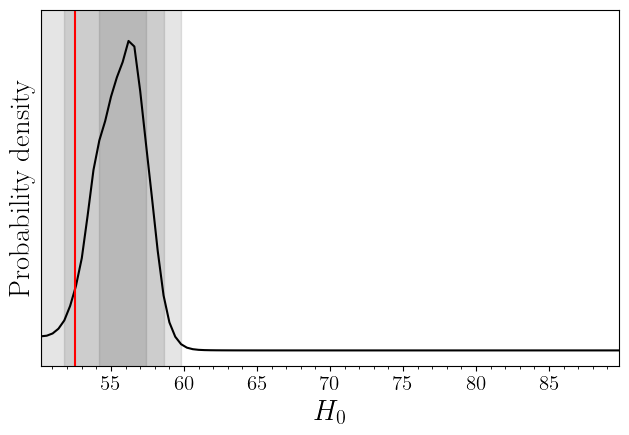

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 64it [00:00, ?it/s]

<Figure size 1500x500 with 0 Axes>

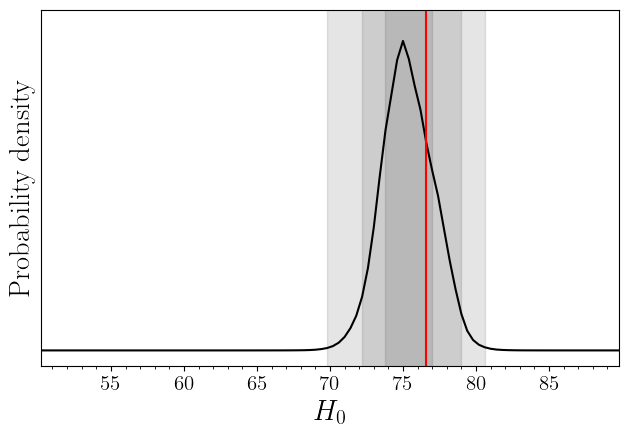

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 64it [00:00, ?it/s]

<Figure size 1500x500 with 0 Axes>

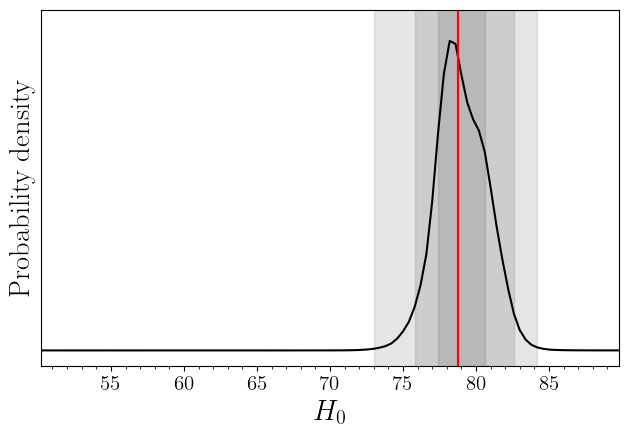

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 64it [00:00, ?it/s]

<Figure size 1500x500 with 0 Axes>

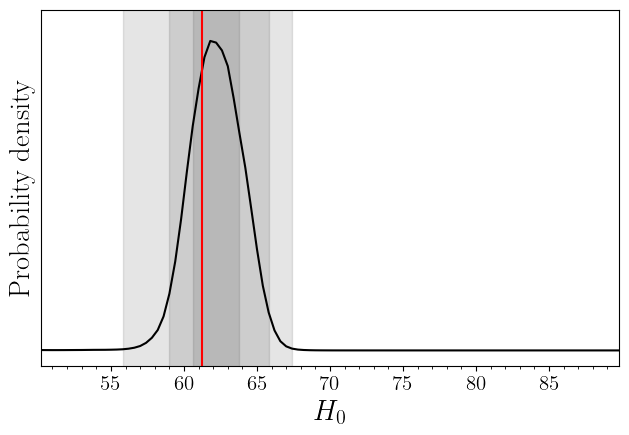

In [124]:
# prior_samples = np.linspace(60,80,1000).astype(np.float32).reshape(-1, 1)
for i in range(4):
    plt.figure(figsize=(15, 5))
    predictions = trainer.infer(network, swyft.Sample(x=x_trues[i]), prior_samples)
    swyft.plot.plot_posterior(predictions, ['z[0]']);
    plt.ylabel('Probability density');
    plt.xlabel(r'$H_0$');
    plt.axvline(z_trues[i], color = 'red');
    
    plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 64it [00:00, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 64it [00:00, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 64it [00:00, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 64it [00:00, ?it/s]

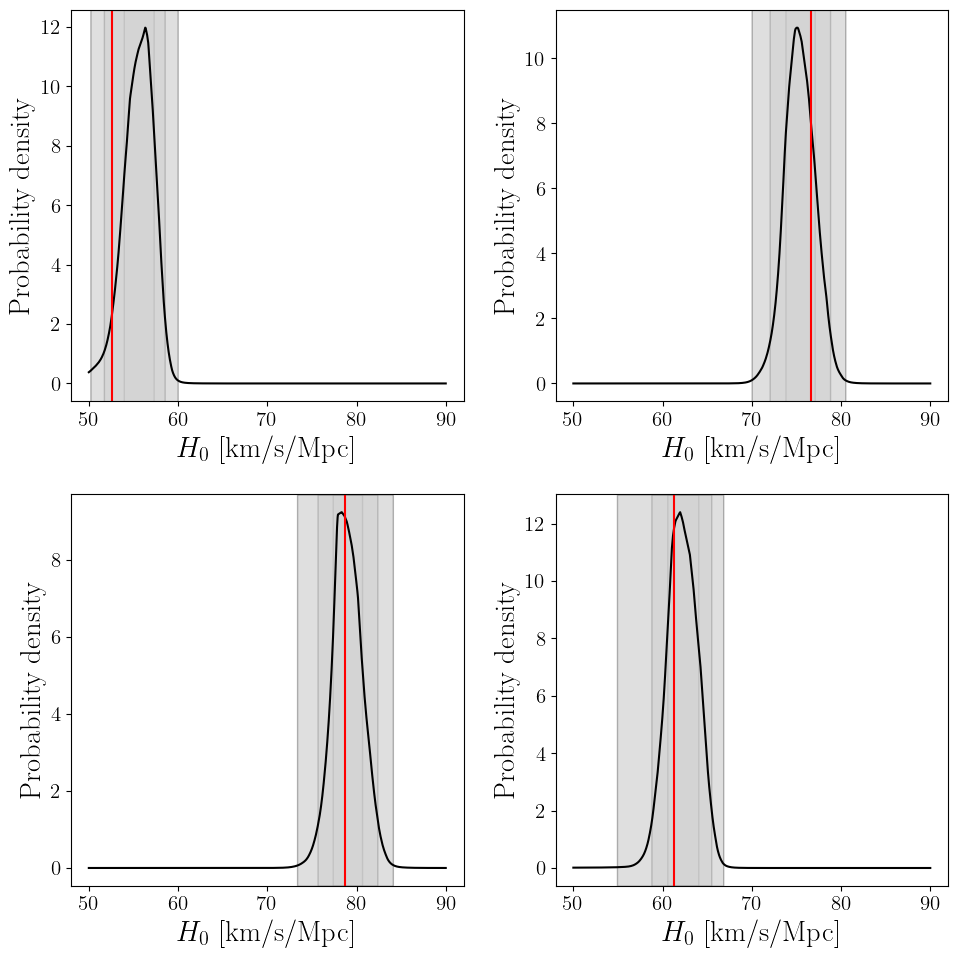

In [127]:
def compute_credible_intervals(z_values, density, levels=[0.682, 0.954, 0.997]):
    """Compute highest density intervals (HDIs) for given credible levels."""
    # # Sort values by z for proper integration
    # sorted_indices = np.argsort(z_values)
    # z_sorted = z_values[sorted_indices]
    # density_sorted = density[sorted_indices]

    # Compute cumulative density function (normalized)
    cdf = np.cumsum(density) / torch.sum(density)

    intervals = []
    for level in levels:
        lower_idx = np.searchsorted(cdf, (1 - level) / 2)
        upper_idx = np.searchsorted(cdf, 1 - (1 - level) / 2)
        intervals.append((z_values[lower_idx], z_values[upper_idx]))

    return intervals

N=2

z_trues = test_samples['z']

x_trues = test_samples['x']

# my_simulator = Simulator(gal_data)

fig_post, axes = plt.subplots(N, N, figsize=(5*N, 5*N))  # Create a NxN grid of subplots
axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

for i in range(N**2):
  x0 = x_trues[i]
  z0 = z_trues[i]
  x0 = x0.astype(np.float32)

  prior_samples = my_simulator.sample(targets=['z'], N=10000)
  prior_samples['z'] = prior_samples['z'].astype(np.float32)
  predictions = trainer.infer(network, swyft.Sample(x=x0), prior_samples)


  # Extract posterior samples and density (and sort)
  z_values = predictions.params.T[0][0]
  z_values, indices = torch.sort(z_values)
  density = np.exp(predictions.logratios.T[0])[indices]

  credible_intervals = compute_credible_intervals(z_values, density)

  axes[i].plot(z_values,density, color = 'k')
  y_min, y_max = axes[i].get_ylim()


  # Shade credible intervals
  shades = ['whitesmoke','gainsboro', 'silver']  # High contrast greys
  for j, (lower, upper) in enumerate(credible_intervals):
      axes[i].fill_between(z_values, np.ones(len(density))*y_min, np.ones(len(density))*y_max,
                          where=(z_values >= lower) & (z_values <= upper),
                          color=shades[j], edgecolor='dimgrey', alpha=0.5)


  axes[i].set_ylabel('Probability density')
  axes[i].set_ylim(y_min, y_max)
  axes[i].set_xlabel(r'$H_0$ [km/s/Mpc]')
  axes[i].axvline(z0, color='red')

plt.tight_layout()  # Adjust spacing
plt.savefig("4panels_posteriors.pdf")

In [ ]:
# # for i in range(len(z_trues)):
# for i in range(9):
#   x0 = x_trues[i]
#   z0 = z_trues[i]
#   x0 = x0.astype(np.float32)

#   prior_samples = my_simulator.sample(targets = ['z'], N = 10000)
#   prior_samples['z'] = prior_samples['z'].astype(np.float32)
#   predictions = trainer.infer(network, swyft.Sample(x = x0), prior_samples)

#   swyft.plot.plot_posterior(predictions, ['z[0]']);
#   plt.ylabel('Probability density');
#   plt.xlabel(r'$H_0$');
#   plt.axvline(z0, color = 'red');
#   plt.show()

# Coverage test

In [129]:
coverage_samples = trainer.test_coverage(network, test_samples, prior_samples)

/home/iliodis/.local/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /sw/arch/RHEL8/EB_production/2023/software/jupyter-s ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 64it [00:00, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 64it [00:00, ?it/s]

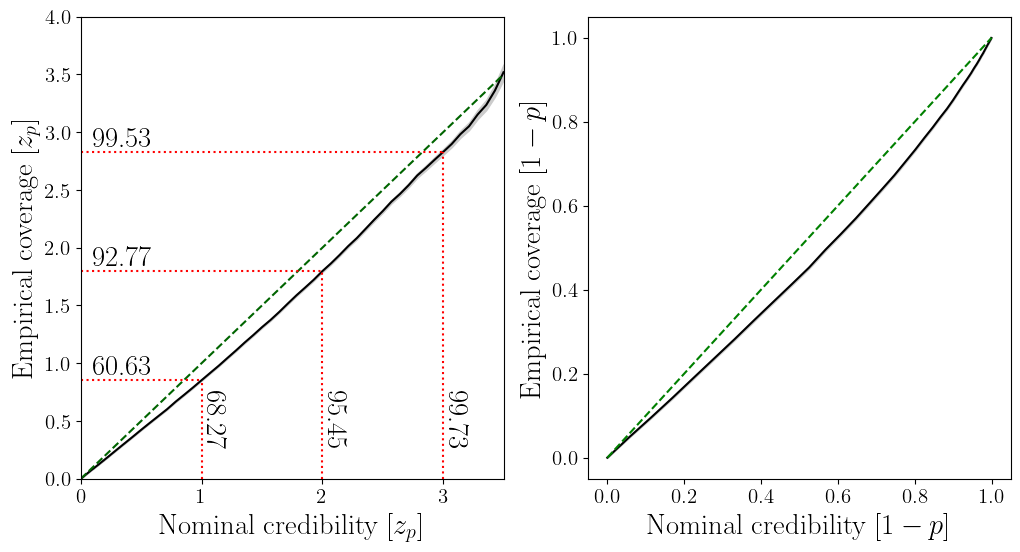

In [134]:
### Coverage
# coverage_samples = trainer.test_coverage(network, test_samples, prior_samples)

fig_cov, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create a NxN grid of subplots

# axes = axes.flatten()
swyft.plot_zz(coverage_samples, "z[0]",ax=axes[0])
swyft.plot_pp(coverage_samples, "z[0]",ax=axes[1])
plt.savefig("coverageplots.pdf")

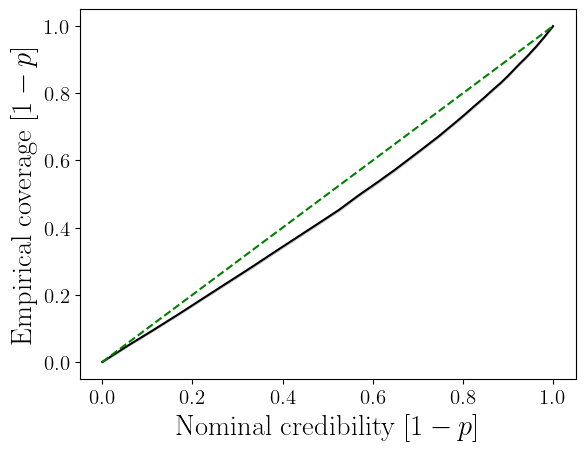

In [130]:
swyft.plot_pp(coverage_samples, "z[0]")

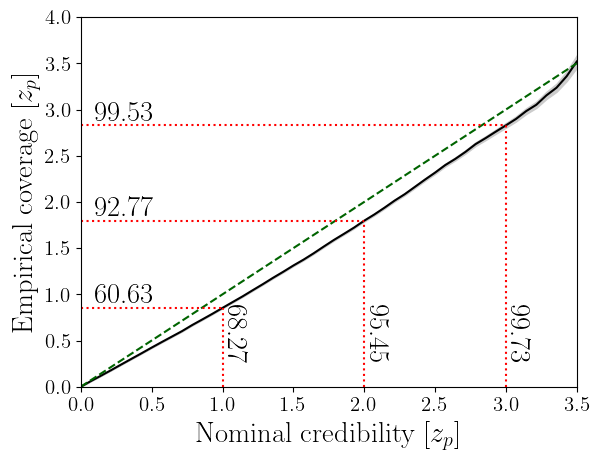

In [131]:
swyft.plot_zz(coverage_samples, "z[0]")


### Questions for Oleg:

*   General metric to check/quantify accuracy and precision for a given architecture+training?  **Coverage tests**
*   Widely used visualization for the above metric, for training performance etc? (like my NS plots)
*   Empirical training loss value?
*   Modify training algorithm i.e. BFGS?
*   Architectures?
*   Why is the following plot different?

- Check Graph networks for points in 3D space
- Transformer neural network
- Coverage tests
- Batch size larger and factor of 2

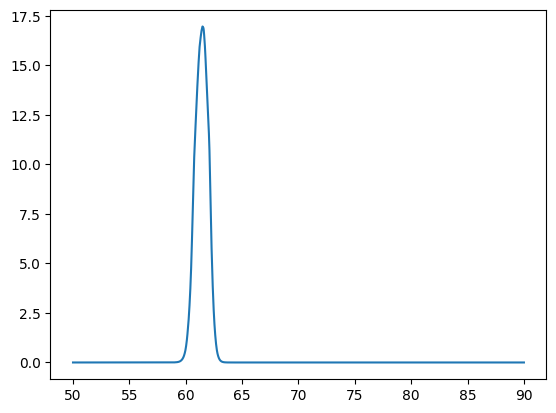

In [ ]:
sorted, indices = torch.sort(predictions.params.T[0][0])

plt.plot(sorted,np.exp(predictions.logratios.T[0])[indices])

tensor([50.0009, 50.0071, 50.0074,  ..., 89.9788, 89.9878, 89.9998])

tensor([88.6749, 53.8136, 85.0065,  ..., 72.2230, 75.7526, 89.0280])

# **Test network**

## Read all

In [ ]:
# gal_data = pd.read_csv('/content/drive/My Drive/MSc_Thesis/SBI_galaxies.csv',index_col=0)
gal_data = pd.read_csv('SBI_galaxies.csv',index_col=0)
gal_data

,unique_gal_id,true_redshift_gal,theta,phi,ra,dec,m1,m2,eta,Mc,iota,psi,tcoal,Phicoal,chi1z,chi2z
0,29502680,0.38121,0.918905,0.164011,0.164011,0.651891,31.568348,2.750740,0.073728,7.179823,1.035960,4.060674,0.005910,1.843524,-0.027583,-0.016516
1,135554767,0.46627,1.069768,0.650964,0.650964,0.501028,5.991733,2.887086,0.219433,3.573849,1.526368,1.376843,0.213507,0.030350,0.024302,0.006612
2,150227216,0.86435,0.868863,0.550906,0.550906,0.701933,6.258491,2.797735,0.213492,3.585719,1.898058,2.732821,0.770435,2.482985,0.026720,0.000330
3,29764296,0.40035,0.894075,0.275507,0.275507,0.676722,21.927137,3.542596,0.119744,7.128157,1.709987,4.887558,0.188614,4.941285,-0.010123,-0.026263
4,154948669,1.01960,0.841345,0.444443,0.444443,0.729451,9.230133,2.784693,0.178053,4.266263,0.601157,4.421171,0.046218,4.398911,-0.011656,-0.016627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,209372773,0.51126,1.547697,1.279312,1.279312,0.023100,5.753950,2.883824,0.222398,3.504940,0.480752,5.592661,0.269833,4.330570,-0.035112,0.023719
146,184370771,0.55982,1.369863,0.737339,0.737339,0.200933,36.306023,4.720411,0.101819,10.417472,1.160562,1.947307,0.738844,1.839095,0.042494,-0.029142
147,501828367,0.73601,0.922182,0.635109,0.635109,0.648614,7.552863,4.122942,0.228426,4.814309,1.257292,1.706434,0.914271,4.351314,0.015904,0.039134
148,148520071,0.69675,1.008468,0.487109,0.487109,0.562328,4.783689,3.152202,0.239434,3.365945,1.364968,4.655038,0.928791,3.098587,0.032892,0.038295


In [ ]:
test_samples_single = torch.load("/content/drive/My Drive/MSc_Thesis/SBI_final_data/SBI_40_test_samples.pth", weights_only=False)
test_samples_mult   = torch.load("/content/drive/My Drive/MSc_Thesis/SBI_final_data/SBI_40x51_test_samples.pth", weights_only=False)

test_samples        = torch.load("/content/drive/My Drive/MSc_Thesis/SBI_final_data/SBI_8160_test_samples.pth", weights_only=False)
train_samples       = torch.load("/content/drive/My Drive/MSc_Thesis/SBI_final_data/SBI_32640_train_samples.pth", weights_only=False)

## Preliminaries

In [ ]:
DEVICE = 'gpu' if torch.cuda.is_available() else 'cpu'

In [ ]:
torch.manual_seed(0)
np.random.seed(0)

In [ ]:
# from re import VERBOSE
class Simulator(swyft.Simulator):
    def __init__(self, params):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.H0s        = np.random.uniform(low=60, high=80, size=len(params))
        self.Nbins      = len(params)
        self.params     = params
        self.redshifts  = params['true_redshift_gal'].values
        self.thetag     = params['theta'].values
        self.phig       = params['phi'].values
        self.pass_events  = []
        self.trust_scores = []
        self.sigmas_arr   = []

    def calc_m(self, z):
        cosmo = FlatLambdaCDM(H0  = z,
                              Om0 = 0.3,
                              Ob0 = 0.044)
        dLs = cosmo.luminosity_distance(self.redshifts).value/1000 #Gpc
        m = np.array([self.thetag,self.phig,dLs]).T
        return m.astype(np.float32)

    def calc_x(self, m):
        temp_df = self.params
        temp_df['dL'] = m.T[2]
        GW_data = EventSimulator(temp_df, filt_snr = 8, filt_err = 0.05, batch = 50)
        GW_data.simulate()
        sigmas = GW_data.host_g[['sigma_theta','sigma_phi','sigma_dL']].values
        self.sigmas_arr.append(sigmas)

        pass_mask = GW_data.host_g['PASS'].values  # Boolean mask (True = trusted event)
        self.pass_events.append(pass_mask)

        invarr = 1/sigmas.T[2] #sigma d_L
        self.trust_scores.append(invarr/np.linalg.norm(invarr))

        result = m + np.random.randn(*np.shape(m)) * sigmas
        return result.astype(np.float32)


    def build(self, graph):  # the print statements are for illustration only
        print("--- Building graph!")
        z = graph.node('z', lambda: np.random.uniform(low=50, high=90))
        m = graph.node('m', self.calc_m, z)
        x = graph.node('x', self.calc_x, m)

        # # Store event trust scores
        # trust_scores = graph.node('trust', lambda: self.pass_events[-1])

        print("--- x =", x)
        print("--- m =", m)
        print("--- z =", z)
        # print("--- trust =", trust_scores)  # Debugging: print trust scores

In [ ]:
my_simulator = Simulator(gal_data)

## Architectures

### Linear MLP

In [ ]:
class LinMLP(swyft.SwyftModule):
    def __init__(self):
        super().__init__()

        # Feature extractor: Flatten and project down to a smaller dimension
        self.embedding = torch.nn.Sequential(
            torch.nn.Flatten(),  # Flatten (150,3) -> (450,)
            torch.nn.Linear(450, 256),  # Reduce to 16 features
            torch.nn.ReLU(),
            # SinActivation(),  # Use sine activation
            torch.nn.Linear(256, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 4),  # Further reduce to 4 features
            torch.nn.ReLU()
        )

        # Log-ratio estimator for a **single** parameter
        self.logratios = swyft.LogRatioEstimator_1dim(
            num_features=4,  # Matches final embedding output
            num_params=1,    # Only one parameter to infer
            varnames='z'
            )

    def forward(self, A, B):
        embedding = self.embedding(A['x'])  # Process input
        logratios = self.logratios(embedding, B['z'].unsqueeze(-1))  # Ensure shape is (batch, 1)
        return logratios

### Non-linear MLP

In [ ]:
class NonLinMLP(swyft.SwyftModule):
    def __init__(self):
        super().__init__()

        # Feature extractor: Flatten and project down to a smaller dimension
        self.embedding = torch.nn.Sequential(
            torch.nn.Flatten(),  # Flatten (150,3) -> (450,)
            torch.nn.Linear(450, 128),  # Reduce to 16 features
            torch.nn.Tanh(),
            # SinActivation(),  # Use sine activation
            torch.nn.Linear(128, 16),
            torch.nn.Tanh(),
            torch.nn.Linear(16, 4),  # Further reduce to 4 features
            torch.nn.Tanh()
        )

        # Log-ratio estimator for a **single** parameter
        self.logratios = swyft.LogRatioEstimator_1dim(
            num_features=4,  # Matches final embedding output
            num_params=1,    # Only one parameter to infer
            varnames='z'
            )

    def forward(self, A, B):
        embedding = self.embedding(A['x'])  # Process input
        logratios = self.logratios(embedding, B['z'].unsqueeze(-1))  # Ensure shape is (batch, 1)
        return logratios

### Mixed MLP

In [ ]:
class MixMLP(swyft.SwyftModule):
    def __init__(self):
        super().__init__()

        # Feature extractor: Flatten and project down to a smaller dimension
        self.embedding = torch.nn.Sequential(
            torch.nn.Flatten(),  # Flatten (150,3) -> (450,)
            torch.nn.Linear(450, 128),  # Reduce to 16 features
            torch.nn.ReLU(),
            # SinActivation(),  # Use sine activation
            torch.nn.Linear(128, 16),
            torch.nn.Tanh(),
            torch.nn.Linear(16, 4),  # Further reduce to 4 features
            torch.nn.ReLU()
        )

        # Log-ratio estimator for a **single** parameter
        self.logratios = swyft.LogRatioEstimator_1dim(
            num_features=4,  # Matches final embedding output
            num_params=1,    # Only one parameter to infer
            varnames='z'
            )

    def forward(self, A, B):
        embedding = self.embedding(A['x'])  # Process input
        logratios = self.logratios(embedding, B['z'].unsqueeze(-1))  # Ensure shape is (batch, 1)
        return logratios

### Periodic MLP

In [ ]:
class SinActivation(torch.nn.Module):
    def forward(self, x):
        return torch.sin(x)

In [ ]:
class PeriodicMLP(swyft.SwyftModule):
    def __init__(self):
        super().__init__()

        # Feature extractor: Flatten and project down to a smaller dimension
        self.embedding = torch.nn.Sequential(
            torch.nn.Flatten(),  # Flatten (150,3) -> (450,)
            torch.nn.Linear(450, 128),  # Reduce to 16 features
            torch.nn.ReLU(),
            torch.nn.Linear(128, 16),
            SinActivation(),  # Use sine activation
            # torch.nn.ReLU(),
            torch.nn.Linear(16, 4),  # Further reduce to 4 features
            torch.nn.ReLU()
        )

        # Log-ratio estimator for a **single** parameter
        self.logratios = swyft.LogRatioEstimator_1dim(
            num_features=4,  # Matches final embedding output
            num_params=1,    # Only one parameter to infer
            varnames='z'
            )

    def forward(self, A, B):
        embedding = self.embedding(A['x'])  # Process input
        logratios = self.logratios(embedding, B['z'].unsqueeze(-1))  # Ensure shape is (batch, 1)
        return logratios


## Sumirizer

In [ ]:
class Sumirizer(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        # self.summarizer = torch.nn.Linear(150, 16)

        # Feature extractor: Flatten and project down to a smaller dimension
        self.embedding = torch.nn.Sequential(
            torch.nn.Flatten(),  # Flatten (150,3) -> (450,)
            torch.nn.Linear(450, 256),  # Reduce to 16 features
            torch.nn.ReLU(),
            # SinActivation(),  # Use sine activation
            torch.nn.Linear(256, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 4),  # Further reduce to 4 features
            torch.nn.ReLU()
        )

        # Log-ratio estimator for a **single** parameter
        self.logratios = swyft.LogRatioEstimator_1dim(
            num_features=4,  # Matches final embedding output
            num_params=1,    # Only one parameter to infer
            varnames='z'
            )

    def forward(self, A, B):
        embedding = self.embedding(A['x'])  # Process input
        logratios = self.logratios(embedding, B['z'].unsqueeze(-1))  # Ensure shape is (batch, 1)
        return logratios

In [ ]:
class Sumirizer(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.summarizer = torch.nn.Linear(Nbins, 3)
        self.logratios = swyft.LogRatioEstimator_1dim(num_features = 1, num_params = 3, varnames = 'z')

    def forward(self, A, B):
        s = self.summarizer(A['x'])
        s = s.unsqueeze(-1)
        return self.logratios(s, B['z']), s

### CNN

In [ ]:
class CNN(swyft.SwyftModule):
    def __init__(self):
        super().__init__()

        # 1D Convolutional Layers
        self.conv_layers = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels=3, out_channels=16, kernel_size=5, padding=2),
            torch.nn.ReLU()
            # torch.nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            # torch.nn.ReLU()
            # torch.nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            # torch.nn.ReLU()
        )

        # Fully connected layers
        self.fc_layers = torch.nn.Sequential(
            torch.nn.Linear(16 * 150, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 8),
            torch.nn.Tanh()
        )

        # Log-ratio estimator
        self.logratios = swyft.LogRatioEstimator_1dim(
            num_features=8,
            num_params=1,
            varnames='z'
        )

    def forward(self, A, B):
        x = A['x'].permute(0, 2, 1)  # Change shape to (batch, 3, 150)
        features = self.conv_layers(x)  # CNN extracts features
        features = features.view(features.shape[0], -1)  # Flatten

        embedding = self.fc_layers(features)
        logratios = self.logratios(embedding, B['z'].unsqueeze(-1))
        return logratios


## Graph neural network

In [ ]:
pip install torch_geometric torch_sparse torch_scatter torch_cluster

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.0 MB/s eta 0:00:00


In [ ]:
import torch.nn as nn
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data, Batch

## Combined Functions

In [ ]:
def train_func(Network,
               train_samples,
               test_samples,
               test_samples_single,
               batch_size = 1024,
               max_epochs = 50):

    trainer = swyft.SwyftTrainer(accelerator=DEVICE, max_epochs = max_epochs)#, limit_val_batches=1.0)  # Add limit_val_batches
    dm = swyft.SwyftDataModule(train_samples, batch_size=1024)


    network = Network()
    trainer.fit(network, dm)

    test_loss        = trainer.test(network, test_samples.get_dataloader(batch_size = 64))[0]
    test_loss_single = trainer.test(network, test_samples_single.get_dataloader(batch_size = 64))[0]

    info_dict = {'max_epochs'       : max_epochs,
                 'epochs'           : trainer.current_epoch,
                 'batch_size'       : batch_size,
                #  'optimizer'        : trainer.optimizers[0],
                 'test_loss'        : test_loss['test_loss'],
                 'test_loss_single' : test_loss_single['test_loss']}

    return (network, info_dict), trainer

def compute_credible_intervals(z_values, density, levels=[0.682, 0.954, 0.997]):
    """Compute highest density intervals (HDIs) for given credible levels."""
    # # Sort values by z for proper integration
    # sorted_indices = np.argsort(z_values)
    # z_sorted = z_values[sorted_indices]
    # density_sorted = density[sorted_indices]

    # Compute cumulative density function (normalized)
    cdf = np.cumsum(density) / torch.sum(density)

    intervals = []
    for level in levels:
        lower_idx = np.searchsorted(cdf, (1 - level) / 2)
        upper_idx = np.searchsorted(cdf, 1 - (1 - level) / 2)
        intervals.append((z_values[lower_idx], z_values[upper_idx]))

    return intervals

def posteriors_and_coverage(network, test_samples, Simulator, gal_data, trainer, N=3):

  z_trues = test_samples['z']

  x_trues = test_samples['x']

  my_simulator = Simulator(gal_data)

  fig_post, axes = plt.subplots(N, N, figsize=(4*N, 4*N))  # Create a NxN grid of subplots
  axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

  for i in range(9):
      x0 = x_trues[i]
      z0 = z_trues[i]
      x0 = x0.astype(np.float32)

      prior_samples = my_simulator.sample(targets=['z'], N=1000)
      prior_samples['z'] = prior_samples['z'].astype(np.float32)
      predictions = trainer.infer(network, swyft.Sample(x=x0), prior_samples)


      # Extract posterior samples and density (and sort)
      z_values = predictions.params.T[0][0]
      z_values, indices = torch.sort(z_values)
      density = np.exp(predictions.logratios.T[0])[indices]

      credible_intervals = compute_credible_intervals(z_values, density)

      axes[i].plot(z_values,density, color = 'k')
      y_min, y_max = axes[i].get_ylim()


      # Shade credible intervals
      shades = ['whitesmoke','gainsboro', 'silver']  # High contrast greys
      for j, (lower, upper) in enumerate(credible_intervals):
          axes[i].fill_between(z_values, np.ones(len(density))*y_min, np.ones(len(density))*y_max,
                              where=(z_values >= lower) & (z_values <= upper),
                              color=shades[j], edgecolor='dimgrey', alpha=0.5)


      axes[i].set_ylabel('Probability density')
      axes[i].set_ylim(y_min, y_max)
      axes[i].set_xlabel(r'$H_0$')
      axes[i].axvline(z0, color='red')

  plt.tight_layout()  # Adjust spacing
  plt.show()


  ### Coverage
  coverage_samples = trainer.test_coverage(network, test_samples, prior_samples)

  fig_cov, axes = plt.subplots(1, 2, figsize=(10, 4))  # Create a NxN grid of subplots

  # axes = axes.flatten()
  swyft.plot_zz(coverage_samples, "z[0]",ax=axes[0])
  swyft.plot_pp(coverage_samples, "z[0]",ax=axes[1])
  plt.show()


  return (fig_post, fig_cov)


def save_func(files,folder_name):

    my_net, my_dict, (my_fig_post, my_fig_cov), (my_fig_post_single, my_fig_cov_single) = files


    folders_path = Path("/content/drive/My Drive/MSc_Thesis/SBI_training_results")

    # Create subfolder
    subfolder_path = folders_path / Path(folder_name)


    if not subfolder_path.exists():
        # Make subfolder
        subfolder_path.mkdir()

        # save net
        net_path = subfolder_path / Path('network.pth')
        torch.save(my_net, net_path)

        # save info dictionary
        dict_path = subfolder_path / Path('diction.json')
        with open(dict_path, "w") as f:
            json.dump(my_dict, f)

        # save figures
        fig_post_path = subfolder_path / Path('posteriors.pdf')
        my_fig_post.savefig(fig_post_path, format="pdf")

        fig_cov_path = subfolder_path / Path('coverage.pdf')
        my_fig_cov.savefig(fig_cov_path, format="pdf")

        # save figures
        fig_post_path_single = subfolder_path / Path('posteriors_single.pdf')
        my_fig_post_single.savefig(fig_post_path_single, format="pdf")

        fig_cov_path_single = subfolder_path / Path('coverage_single.pdf')
        my_fig_cov_single.savefig(fig_cov_path_single, format="pdf")

        print('Files saved successfully!')
    else:
        print('Folder already exists!')
    return


def train_test_save(Network,
                    train_samples,
                    test_samples,
                    test_samples_single,
                    subfolder_name,
                    batch_size = 1024,
                    max_epochs = 50):

  folders_path = Path("/content/drive/My Drive/MSc_Thesis/SBI_training_results")

  subfolder_path = folders_path / subfolder_name
  # Check for subfolder
  if subfolder_path.exists():
    print('Folder already exists!')
    return

  # Train
  (network, info_dict), trainer = train_func( Network,
                                              train_samples,
                                              test_samples,
                                              test_samples_single,
                                              batch_size = batch_size,
                                              max_epochs = max_epochs)

  # Test
  figures = posteriors_and_coverage(network, test_samples, Simulator, gal_data, trainer)

  # Test single
  figures_single = posteriors_and_coverage(network, test_samples_single, Simulator, gal_data, trainer)

  # Gather
  files = network, info_dict, figures, figures_single

  # Save
  save_func(files, folder_name = subfolder_name)

  return

## Train, test, save

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type                   | Params
------------------------------------------------------
0 | summarizer | Linear                 | 2.4 K 
1 | embedding  | Sequential             | 119 K 
2 | logratios  | LogRatioEstimator_1dim | 17.6 K
------------------------------------------------------
139 K     Trainable params
0         Non-trainable par

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Reloading best model: /content/lightning_logs/version_4/checkpoints/epoch=15-step=416.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    -1.1665003299713135    │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    -1.2161775827407837    │
└───────────────────────────┴───────────────────────────┘

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--- Building graph!
--- x = Node('x', <bound method Simulator.calc_x of <__main__.Simulator object at 0x78feb4ce9990>>, (Node('m', <bound method Simulator.calc_m of <__main__.Simulator object at 0x78feb4ce9990>>, (Node('z', <function Simulator.build.<locals>.<lambda> at 0x78feb50ba200>, ()),)),))
--- m = Node('m', <bound method Simulator.calc_m of <__main__.Simulator object at 0x78feb4ce9990>>, (Node('z', <function Simulator.build.<locals>.<lambda> at 0x78feb50ba200>, ()),))
--- z = Node('z', <function Simulator.build.<locals>.<lambda> at 0x78feb50ba200>, ())


Predicting: 26it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 26it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 26it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 26it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 26it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 26it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 26it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 26it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 26it [00:00, ?it/s]

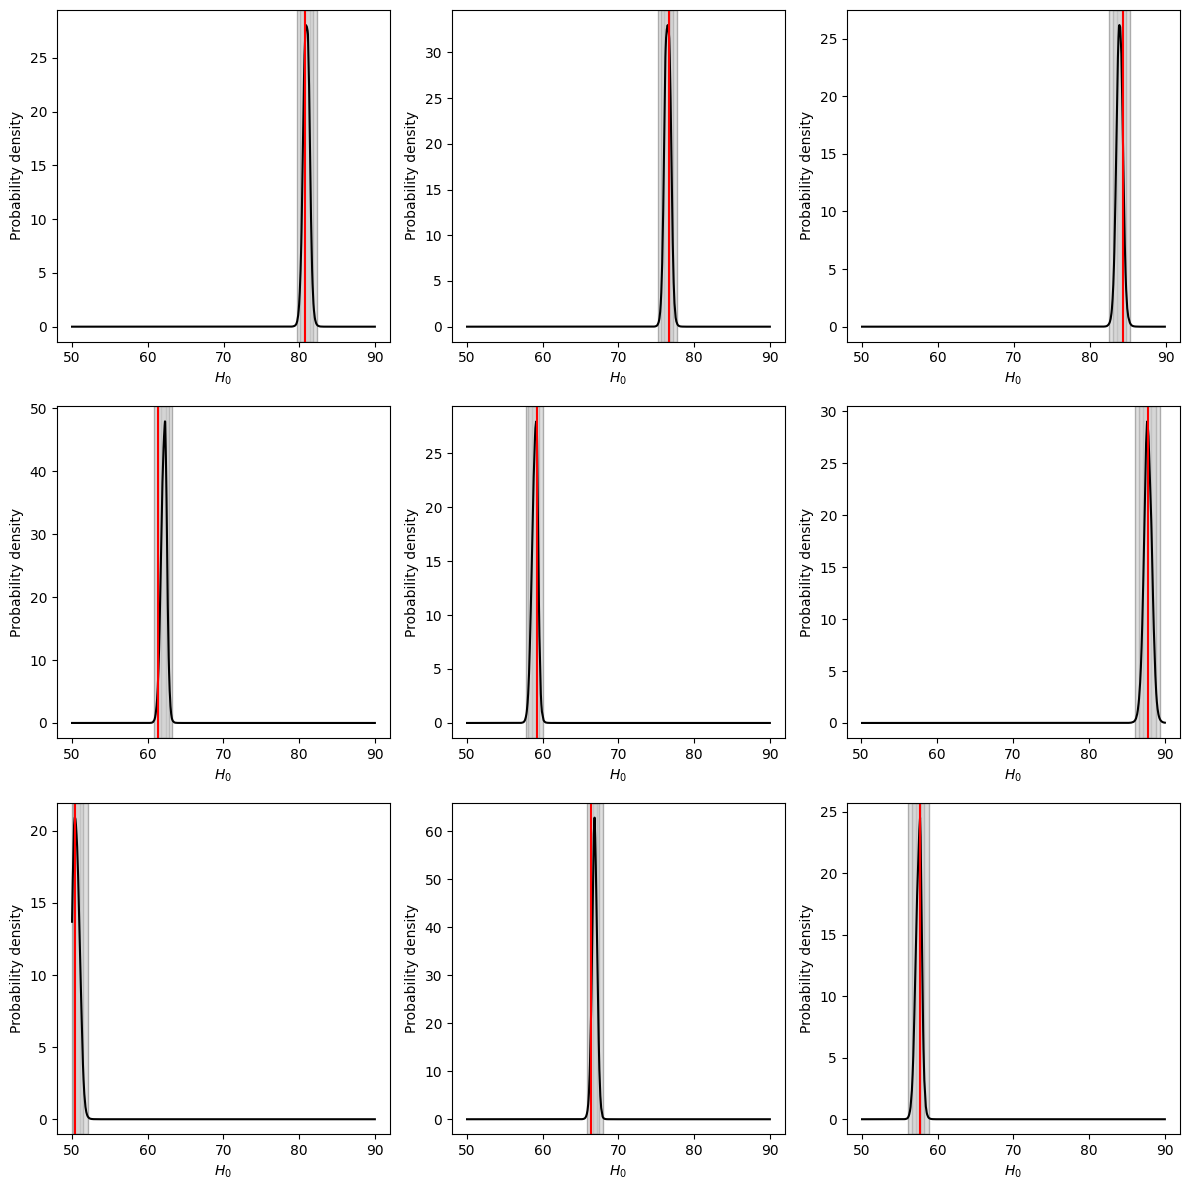

INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 26it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 26it [00:00, ?it/s]

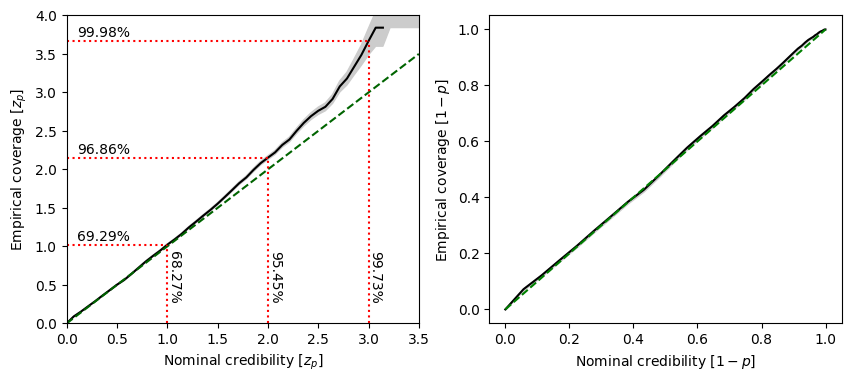

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--- Building graph!
--- x = Node('x', <bound method Simulator.calc_x of <__main__.Simulator object at 0x78ff45468d50>>, (Node('m', <bound method Simulator.calc_m of <__main__.Simulator object at 0x78ff45468d50>>, (Node('z', <function Simulator.build.<locals>.<lambda> at 0x78feb4c1fb00>, ()),)),))
--- m = Node('m', <bound method Simulator.calc_m of <__main__.Simulator object at 0x78ff45468d50>>, (Node('z', <function Simulator.build.<locals>.<lambda> at 0x78feb4c1fb00>, ()),))
--- z = Node('z', <function Simulator.build.<locals>.<lambda> at 0x78feb4c1fb00>, ())


Predicting: 26it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 26it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 26it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 26it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 26it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 26it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 26it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 26it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 26it [00:00, ?it/s]

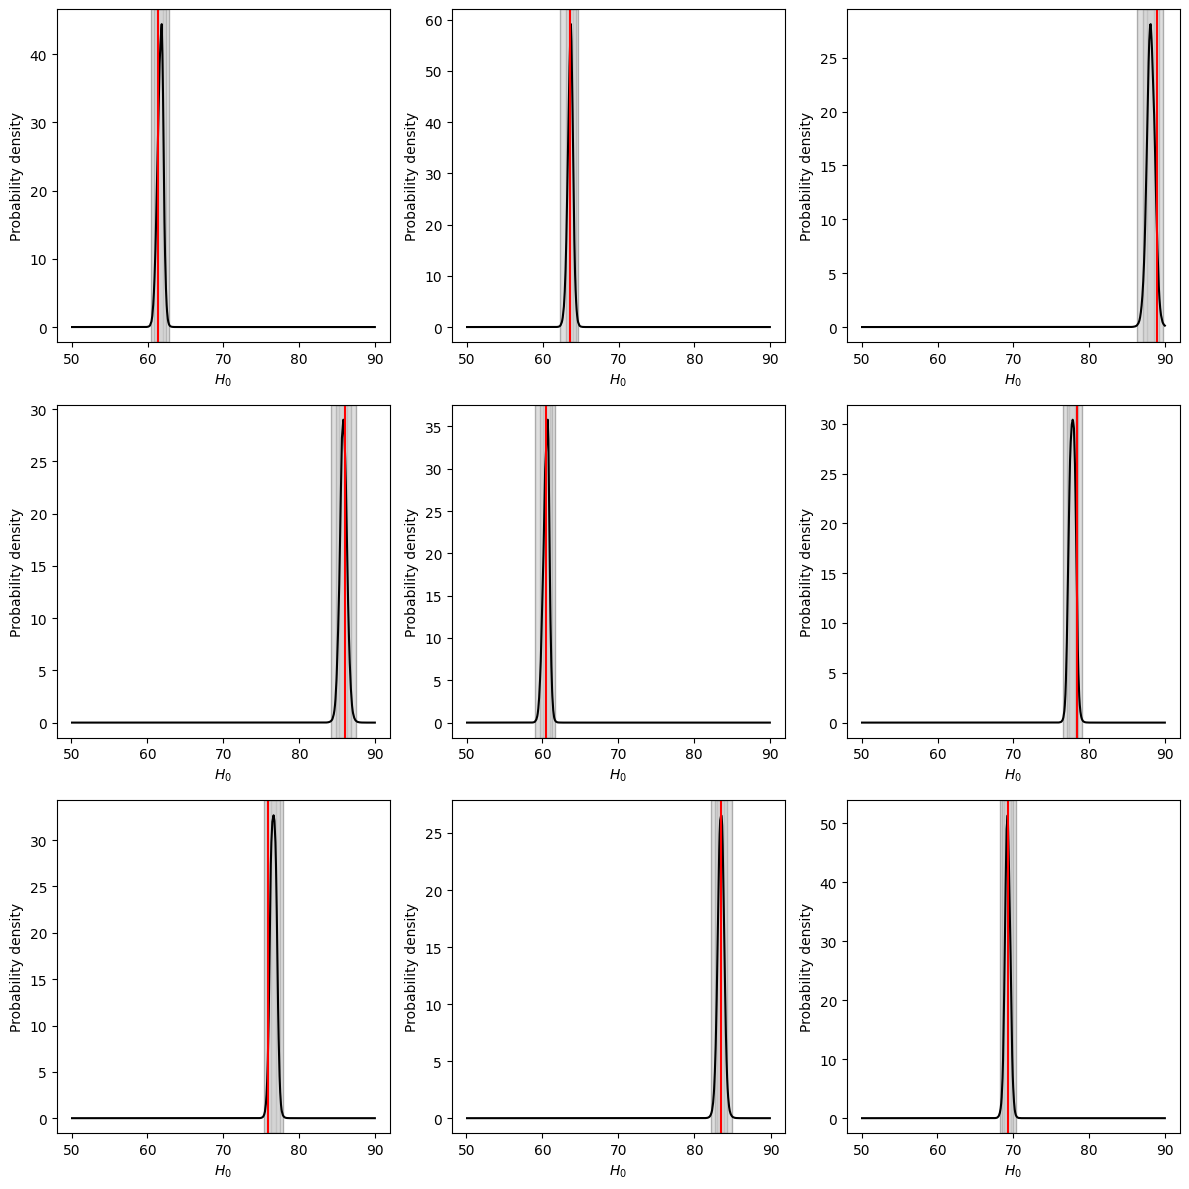

INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 26it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 26it [00:00, ?it/s]

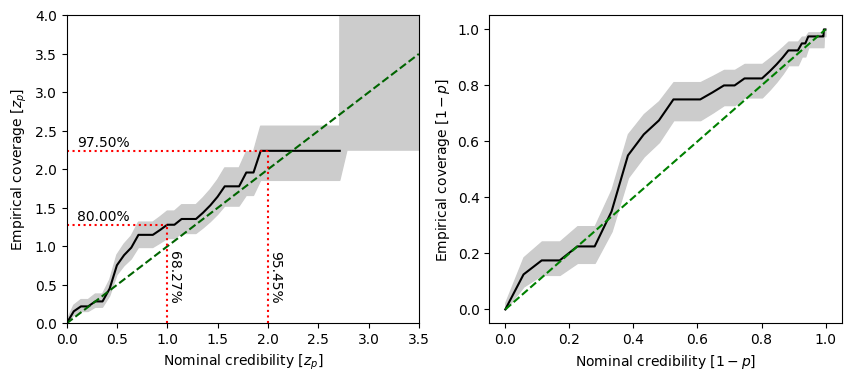

Files saved successfully!


In [ ]:
trainer = train_test_save(Sumirizer,
                          train_samples,
                          test_samples,
                          test_samples_single,
                          subfolder_name = 'Sumirizer',
                          batch_size = 1024,
                          max_epochs = 50)